In [1]:
#### semopy ####
import numpy as np
import scipy
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import statsmodels.api as sma
jpn_fonts=list(np.sort([ttf for ttf in fm.findSystemFonts() if 'msgothic' in ttf]))
jpn_font=jpn_fonts[0]
prop = fm.FontProperties(fname=jpn_font)
sns.set()

In [2]:
df_cps1 = pd.read_stata('https://users.nber.org/~rdehejia/data/cps_controls.dta')
df_nsw = pd.read_stata('https://users.nber.org/~rdehejia/data/nsw_dw.dta')
display(df_cps1.head())
display(df_nsw.head())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [3]:
# df_nswの対照群をdf_cps1に入れ替える
tr_col = 'treat' # 介入変数
all_col = ['age','education','black','hispanic','married','nodegree','re74','re75','re78']
exp_col = ['age','education','black','hispanic','married','nodegree','re74','re75'] # 共変量
df_nswcps1 = pd.concat([df_nsw[df_nsw[tr_col] == 1], df_cps1], ignore_index=False).reset_index(drop=True)
display(df_nswcps1)
display(df_nswcps1.treat.value_counts().reset_index())

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,0.000000,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,0.000000,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,0.000000,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,0.000000,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,0.000000,289.789886
...,...,...,...,...,...,...,...,...,...,...,...
16172,CPS1,0.0,22.0,12.0,1.0,0.0,0.0,0.0,3975.352051,6801.435059,2757.437988
16173,CPS1,0.0,20.0,12.0,1.0,0.0,1.0,0.0,1445.938965,11832.240234,6895.071777
16174,CPS1,0.0,37.0,12.0,0.0,0.0,0.0,0.0,1733.951050,1559.370972,4221.865234
16175,CPS1,0.0,47.0,9.0,0.0,0.0,1.0,1.0,16914.349609,11384.660156,13671.929688


,index,treat
0,0.0,15992
1,1.0,185


In [5]:
# 傾向スコアのためのモデル作成
def model_lr(X_train_std, y_train):
    model = LogisticRegression(max_iter=10000, C=500) # ロジスティック回帰
    model.fit(X_train_std, y_train)

    pred = model.predict(X_train_std)
    pred_proba = model.predict_proba(X_train_std)
    return model, pred, pred_proba[:,1]

In [6]:
X_train = df_nswcps1[exp_col].copy() # 共変量
y_train = df_nswcps1[tr_col].copy() # 介入変数
sc = sklearn.preprocessing.StandardScaler() # 標準化
X_train_std = sc.fit_transform(X_train) # 標準化
# ロジスティック回帰
model, pred, pred_proba = model_lr(X_train_std, y_train)

result1 = df_nswcps1.copy()
result1['user_id'] = range(len(result1))
result1['Zscore'] = pred_proba
result1 = result1[['user_id', tr_col, 'Zscore']+exp_col]

In [8]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col='flg', match_id='user_id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

In [9]:
match_results_df = matching(result1, z_col='Zscore', tr_col='treat', match_id='user_id')
display(match_results_df)

185it [00:00, 30823.32it/s]

0.01078770141480967


,Tr,Ctl,Tr_zscore,Ctl_zscore,diff
0,103,2781,0.487435,0.487435,0.000000e+00
1,52,7777,0.487435,0.487435,0.000000e+00
2,104,2768,0.486491,0.486491,0.000000e+00
3,44,7776,0.485547,0.486491,9.440275e-04
4,79,11530,0.483659,0.484403,7.432527e-04
...,...,...,...,...,...
178,176,7807,0.002528,0.002526,2.798810e-06
179,9,865,0.001825,0.001825,0.000000e+00
180,123,5455,0.001226,0.001227,4.810705e-07
181,184,3488,0.001059,0.001060,6.632920e-08


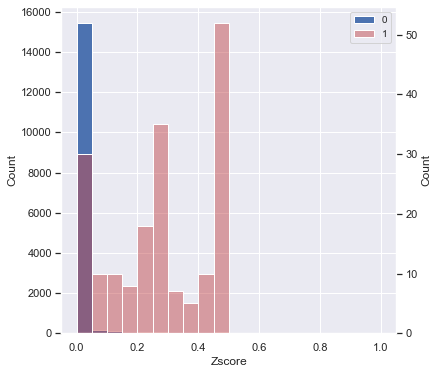

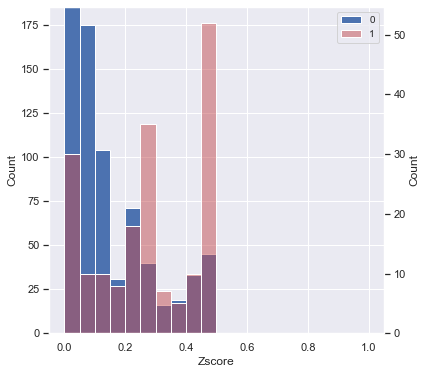

In [31]:
# 傾向スコアのヒストグラム
def zscore_hist(df01, df02, lim=None, vmax=None):
    fig=plt.figure(figsize=(6,6))
    ax = plt.subplot(1,1,1)
    ax2 = ax.twinx()
    sns.histplot(df01, binwidth=0.05, binrange=(0,1), ax=ax, kde=False, label='0', color ='b', alpha=1.)
    sns.histplot(df02, binwidth=0.05, binrange=(0,1), ax=ax2, kde=False, label='1', color ='r', alpha=0.5)
    ax2.grid(False)
    if lim=='zoom':
        ax.set_ylim(0, len(df02)*1)
    elif lim=='same':
        ax.set_ylim(0, len(df02))
        ax2.set_ylim(0, len(df02))
    elif lim=='custom':
        ax.set_ylim(0, vmax)
        ax2.set_ylim(0, vmax)
    else:
        pass
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1+h2, l1+l2, loc='upper right', fontsize=10)
    plt.show()
    
# 傾向スコアヒストグラム マッチング前
df01 = result1[result1[tr_col]==0]['Zscore']
df02 = result1[result1[tr_col]>0]['Zscore']
zscore_hist(df01, df02, lim=None)
zscore_hist(df01, df02, lim='zoom') # 縦軸拡大

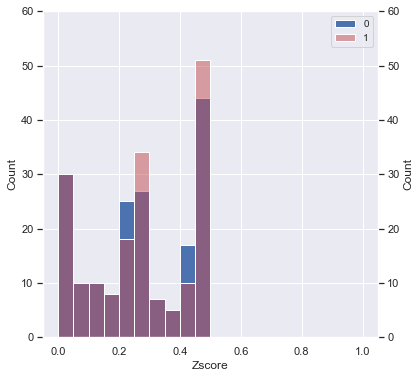

In [32]:
# 傾向スコアヒストグラム マッチング後
df01 = result1[result1['user_id'].isin(match_results_df['Ctl'].unique())]['Zscore']
df02 = result1[result1['user_id'].isin(match_results_df['Tr'].unique())]['Zscore']
zscore_hist(df01, df02, lim='custom', vmax=60)

In [54]:
# 共変量のヒストグラム
def histhist(result1, Ctls, Trs, exp_cols, wid_ratio=20, match=False):
    dim = len(exp_cols)
    fig=plt.figure(figsize=(21,14))
    plt.rcParams['font.family'] = prop.get_name()
    for i, col in tqdm(enumerate(exp_cols)):
        vmin=result1[col].min()
        vmax=result1[col].max()
        VAL = Ctls[col].copy()
        VAL2 = Trs[col].copy()

        wid = round(vmax/wid_ratio)
        if wid==0 or round(wid)==0:
            wid=0.1

        ax = plt.subplot(round(np.ceil(dim/np.sqrt(dim))), round(np.ceil(dim/np.sqrt(dim))), i+1)
        ax2 = ax.twinx()
        sns.histplot(VAL.to_numpy()
                     , binwidth=wid
                     , binrange=(0,vmax)
                     , ax=ax, kde=False, label='0', color ='b', alpha=1.)
        sns.histplot(VAL2.to_numpy()
                     , binwidth=wid
                     , binrange=(0,vmax)
                     , ax=ax2, kde=False, label='1', color ='r', alpha=0.5)
        ax2.grid(False)
        if match:
            ax.set_ylim(0, len(VAL2))
            ax2.set_ylim(0, len(VAL2))
        ax.set_title(col+', binwidth:'+str(np.round(wid, 3)))
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1+h2, l1+l2, loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

8it [00:00,  9.80it/s]


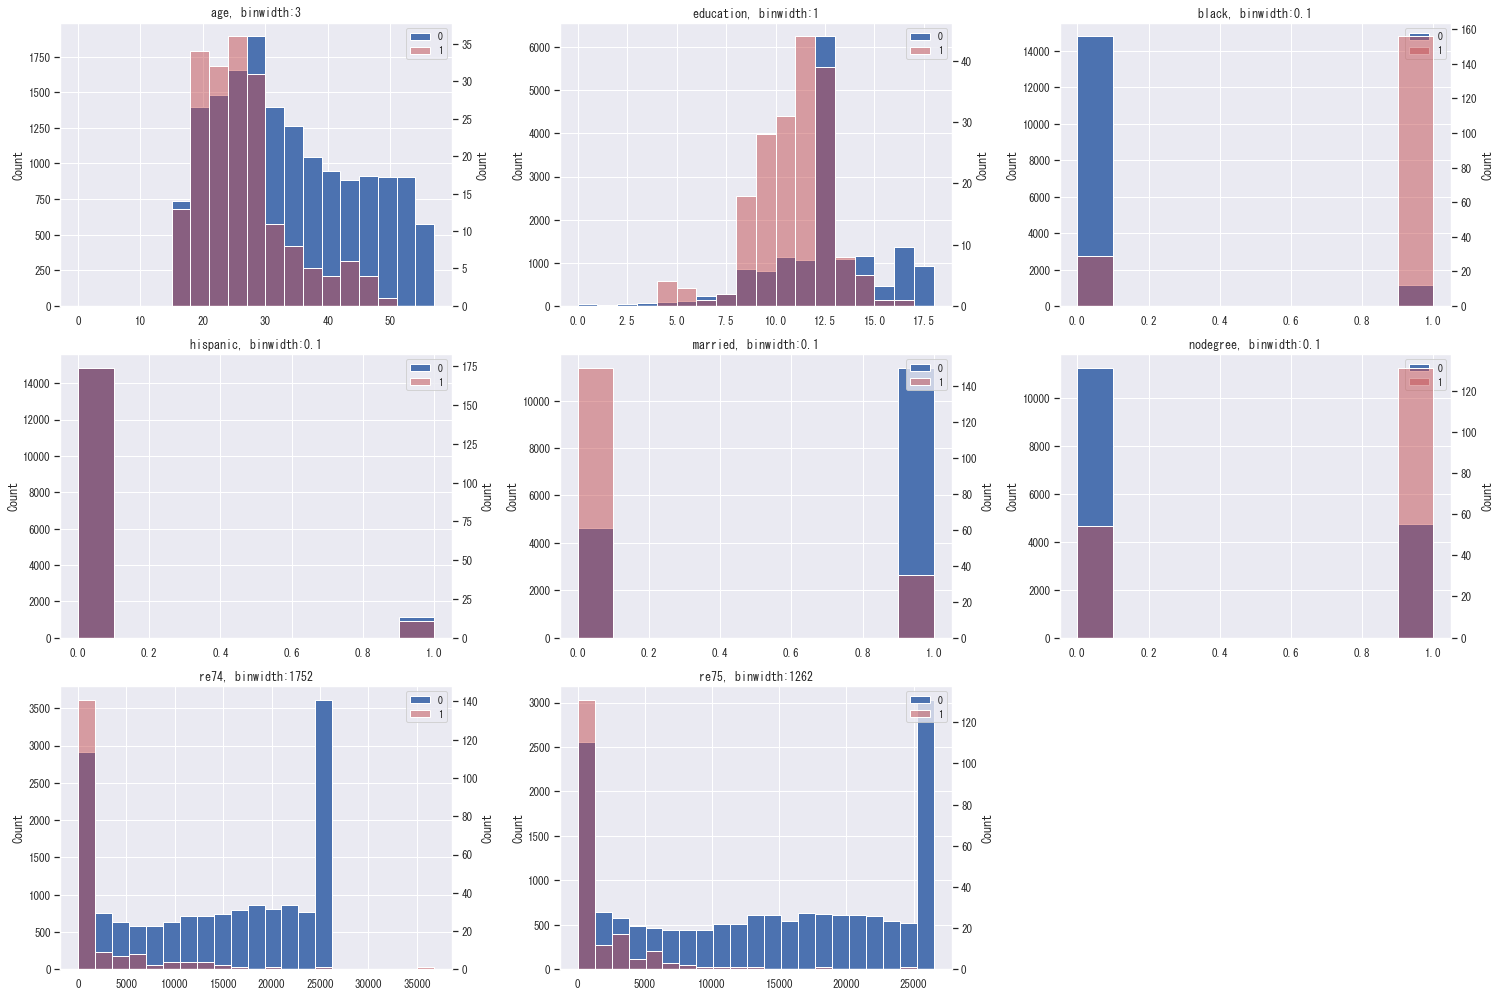

In [55]:
# マッチング前
Ctls = df_nswcps1[df_nswcps1[tr_col]==0].copy() # 対照群
Trs = df_nswcps1[df_nswcps1[tr_col]>0].copy() # 処理群
histhist(df_nswcps1, Ctls, Trs, exp_col) # 共変量ヒストグラム マッチング前

8it [00:00, 11.44it/s]


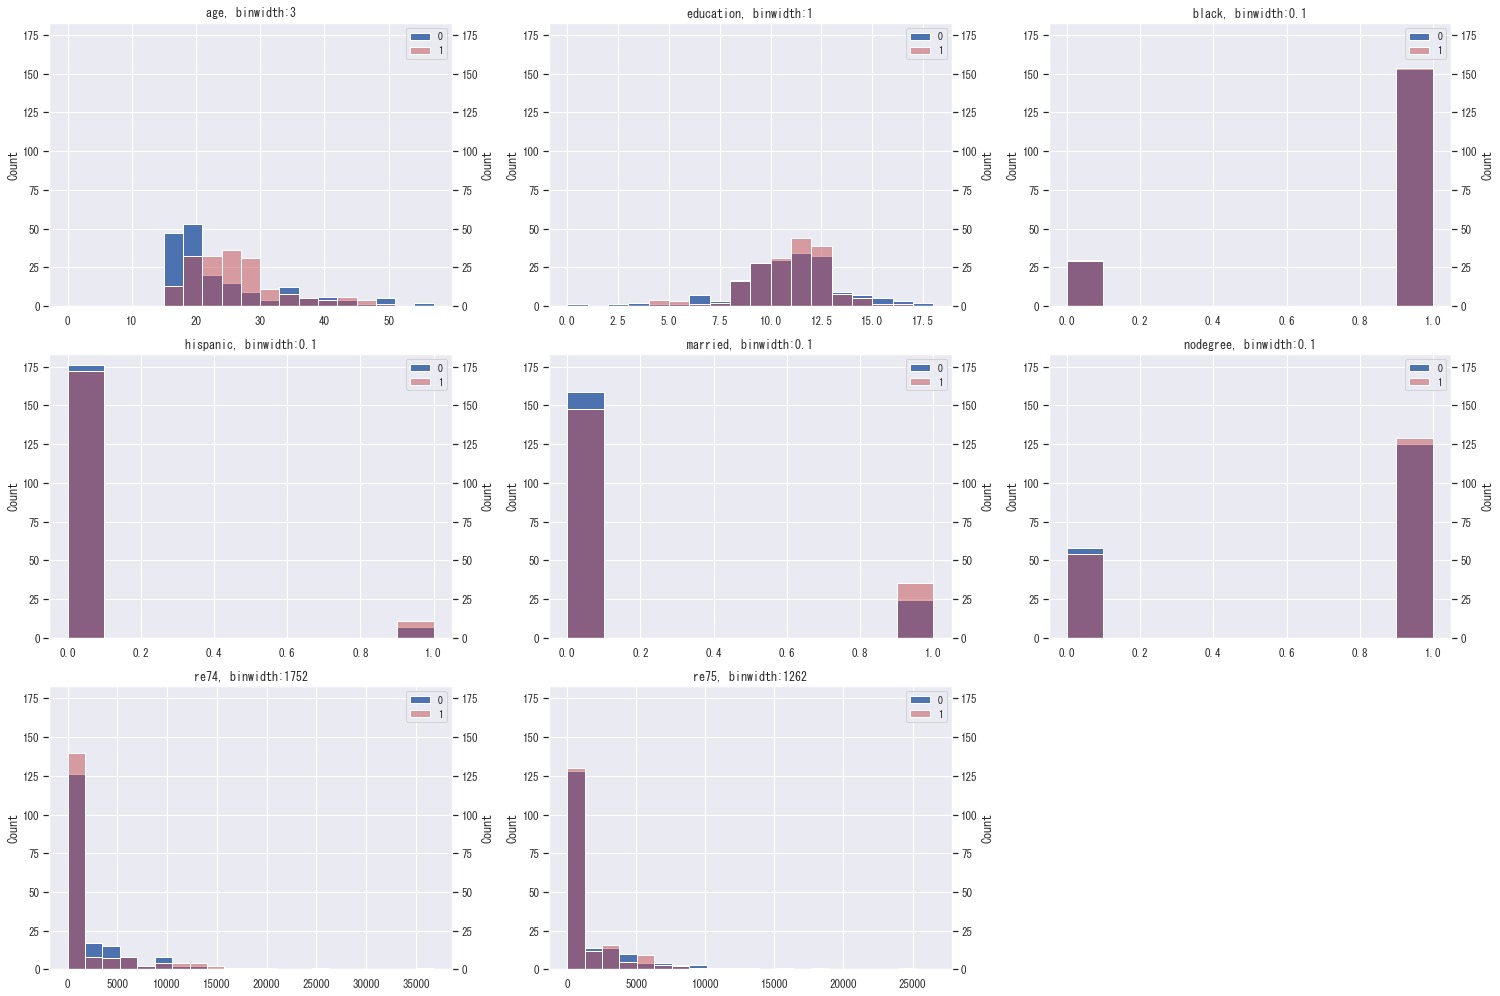

In [56]:
# マッチング後
Ctls = result1[result1['user_id'].isin(match_results_df['Ctl'].unique())].copy() # 対照群
Trs = result1[result1['user_id'].isin(match_results_df['Tr'].unique())].copy() # 処理群
histhist(result1, Ctls, Trs, exp_col, match=True) # 共変量ヒストグラム マッチング後

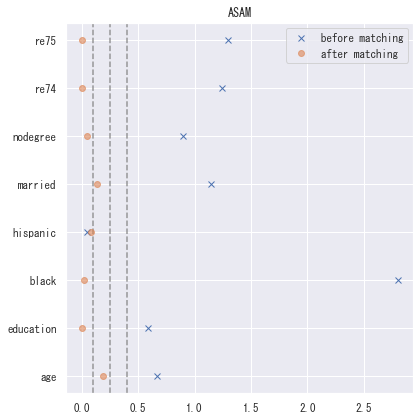

In [42]:
# 標準化平均差プロット
def love_plot(result1, match_results_df, exp_cols
              , tr_col='flg', match_id='user_id', visual=True):
    # 処置群と対照群の共変量の平均の差
    asamCtlMean = result1[result1[tr_col]==0][exp_cols].mean()-result1[result1[tr_col]>0][exp_cols].mean()
    # 共変量の標準偏差
    asamCtlStd =result1[exp_cols].std() 
    # 標準化平均差
    asamCtl = asamCtlMean.abs()/asamCtlStd
    
    # マッチング後の処置群と対照群の共変量の平均の差
    asamTrMean = result1[result1[match_id].isin(match_results_df['Ctl'].unique())][exp_cols].mean()-result1[result1[match_id].isin(match_results_df['Tr'].unique())][exp_cols].mean()
    # マッチング後の共変量の標準偏差
    asamTrStd =result1[exp_cols].std() 
    # マッチング後の標準化平均差
    asamTr = asamTrMean.abs()/asamTrStd
    if visual:
        fig=plt.figure(figsize=(6,6))
        plt.rcParams['font.family'] = prop.get_name()
        plt.axvline(0.1, ls='--', c='gray', alpha=0.8)
        plt.axvline(0.25, ls='--', c='gray', alpha=0.8)
        plt.axvline(0.4, ls='--', c='gray', alpha=0.8)
        plt.plot(asamCtl.to_numpy(), asamCtl.index, marker='x', ls='', label='before matching')
        plt.plot(asamTr.to_numpy(), asamTr.index, marker='o', ls='', label='after matching', alpha=0.6)
        plt.legend()
        plt.title('ASAM')
        plt.tight_layout()
        plt.show()
    return asamCtl, asamTr, asamCtlMean, asamTrMean

asamCtl, asamTr, asamCtlMean, asamTrMean = love_plot(result1, match_results_df, exp_col
                                                     , tr_col=tr_col, match_id='user_id', visual=True)

In [53]:
# 回帰分析NSW
# statsmodelでは、切片を必要とする線形回帰のモデル式の場合、全要素が1.0の列を説明変数の先頭に追加する必要がある
X = sma.add_constant(df_nsw[exp_col+[tr_col]]) # 全要素が1.0の列を先頭に追加
est = sma.OLS(df_nsw['re78'], X)
est_trained = est.fit()
print(est_trained.summary())

# 回帰分析NSW+CPS(マッチング前)
X = sma.add_constant(df_nswcps1[exp_col+[tr_col]])
est = sma.OLS(df_nswcps1['re78'], X)
est_trained = est.fit()
print(est_trained.summary())

# 回帰分析NSW+CPS(マッチング後)
df_nswcps1_match = df_nswcps1.copy()
df_nswcps1_match['user_id'] = range(len(df_nswcps1_match))
df_nswcps1_match = df_nswcps1_match[(df_nswcps1_match['user_id'].isin(match_results_df['Ctl'].unique()))\
                                    |(df_nswcps1_match['user_id'].isin(match_results_df['Tr'].unique()))].copy()
X = sma.add_constant(df_nswcps1_match[exp_col+[tr_col]])
est = sma.OLS(df_nswcps1_match['re78'], X)
est_trained = est.fit()
print(est_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     2.804
Date:                Wed, 05 Oct 2022   Prob (F-statistic):            0.00329
Time:                        23:19:40   Log-Likelihood:                -4534.2
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        785.0614   3374.969      0.233      0.8

In [43]:
# 回帰分析NSW
lm = sklearn.linear_model.LinearRegression()
lm.fit(df_nsw[exp_col+[tr_col]], df_nsw['re78'])
print(lm.feature_names_in_[-1])
print(lm.coef_[-1], '\n')

# 回帰分析NSW+CPS(マッチング前)
lm = sklearn.linear_model.LinearRegression()
lm.fit(df_nswcps1[exp_col+[tr_col]], df_nswcps1['re78'])
print(lm.feature_names_in_[-1])
print(lm.coef_[-1], '\n')

# 回帰分析NSW+CPS(マッチング後)
df_nswcps1_match = df_nswcps1.copy()
df_nswcps1_match['user_id'] = range(len(df_nswcps1_match))
df_nswcps1_match = df_nswcps1_match[(df_nswcps1_match['user_id'].isin(match_results_df['Ctl'].unique()))\
                                    |(df_nswcps1_match['user_id'].isin(match_results_df['Tr'].unique()))].copy()

lm = sklearn.linear_model.LinearRegression()
lm.fit(df_nswcps1_match[exp_col+[tr_col]], df_nswcps1_match['re78'])
print(lm.feature_names_in_[-1])
print(lm.coef_[-1], '\n')

treat
1676.3431 

treat
699.13184 

treat
1704.0056 

